In [1]:
import sys
sys.path.append("..")
from plot_utils import *
from BTwins.utils import calc_lambda

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.distributions import Beta
from torch.distributions.dirichlet import Dirichlet
from tqdm import tqdm
from torchvision import transforms
from sklearn.linear_model import LogisticRegression
#
from utils import *
from functions import *

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, d_in, d_out, batch_norm):
        super().__init__()
        if batch_norm:
            self.ff = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.BatchNorm1d(d_out),
                nn.ReLU(inplace=True)
            )
        else:
            self.ff = nn.Sequential(
                nn.Linear(d_in, d_out),
                nn.ReLU(inplace=True)
            )
    def forward(self, x):
        return self.ff(x)

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
    
class Net(nn.Module):
    def __init__(self, d_in, d_hid, n_hid, d_out, batch_norm=False):
        super().__init__()
        self.d_in = d_in
        self.d_out = d_out
        self.n_hid = n_hid
        self.d_hid = d_hid
        
        self.dims = [d_in] + [d_hid] * n_hid
        self.bn = nn.BatchNorm1d(d_out,affine=False)
        layers = []
        for idx in range(len(self.dims) - 1):
            layers.append(BasicBlock(self.dims[idx], self.dims[idx + 1], batch_norm))
        layers.append(nn.Linear(self.dims[-1], d_out))
        layers.append(nn.Sigmoid())
        self.backbone = nn.Sequential(*layers)
    def forward(self, x):
        return self.backbone(x)

class GMDist():
    def __init__(self, mus, stds, alphas):
        assert mus.shape == stds.shape
        assert alphas.sum() == 1
        if len(mus.shape) == 1:
            mus = mus.reshape((1, -1))
            stds = sts.reshape((1, -1))
        assert mus.shape[0] == len(alphas)
        self.mus = mus
        self.stds = stds
        self.alphas = alphas
        #
        self.dist_cat = torch.distributions.Categorical(alphas)
    
    def sample(self, n, shuffle=True):
        y = self.dist_cat.sample((n,))
        n_subsamples = torch.bincount(y)
        y = y.sort()[0]
        x = []
        for idx, n_sub in enumerate(n_subsamples):
            x.append(torch.distributions.Normal(self.mus[idx], self.stds[idx]).sample((n_sub,)))
        x = torch.cat(x)
        if shuffle:
            idcs = torch.randperm(x.size()[0]) 
            x = x[idcs]
            y = y[idcs]
        return x, y
    
    def sample_barlow(self, n, shuffle=True):
        y = self.dist_cat.sample((n,))
        n_subsamples = torch.bincount(y)
        y = y.sort()[0]
        x1 = []
        x2 = []
        for idx, n_sub in enumerate(n_subsamples):
            x1.append(torch.distributions.Normal(self.mus[idx], self.stds[idx]).sample((n_sub,)))
            x2.append(torch.distributions.Normal(self.mus[idx], self.stds[idx]).sample((n_sub,)))
        x1 = torch.cat(x1)
        x2 = torch.cat(x2)
        if shuffle:
            idcs = torch.randperm(x1.size()[0]) 
            x1 = x1[idcs]
            x2 = x2[idcs]
            y = y[idcs]
        return (x1, x2), y

def get_normalizer(x):
    norm_mean = x.mean(axis=0)
    norm_std = (x - norm_mean).std(axis=0)
    #
    def normalize(samples):
        return (samples - norm_mean) / norm_std
    return normalize

def normalize_z(z, eps):
    return (z - z.mean(axis=0)) / (torch.sqrt(z.var(axis=0)) + eps)

def reshape_(x):
    if len(x.shape) == 1:
        x = x.reshape((-1, 1))
    return x

def cc_norm(x, debug=False, eps=1e-5):
    x = reshape_(x)
    
    # unit variance
    if eps > 0:
        x = (x - x.mean(axis=0)) / torch.sqrt(x.var(axis=0) + eps)
    else:
        x = (x - x.mean(axis=0)) / x.std()
    
    if debug:
        print("mv(X)", x.mean(axis=0), x.var(axis=0))
    #
    return x

In [4]:
for d in [2, 4, 8, 16, 32, 64, 128, 512]:
    lmbda = calc_lambda(d)
    g = d / ((d**2 - d) * lmbda)
    h = ((d**2 - d) * lmbda) / d
    print("{:>4d}: {:8.4f} on/off={:.4f} off/on={:8.4f}".format(d,lmbda, g, h))

   2:  40.9836 on/off=0.0244 off/on= 40.9836
   4:  13.6612 on/off=0.0244 off/on= 40.9836
   8:   5.8548 on/off=0.0244 off/on= 40.9836
  16:   2.7322 on/off=0.0244 off/on= 40.9836
  32:   1.3221 on/off=0.0244 off/on= 40.9836
  64:   0.6505 on/off=0.0244 off/on= 40.9836
 128:   0.3227 on/off=0.0244 off/on= 40.9836
 512:   0.0802 on/off=0.0244 off/on= 40.9836


# Beta-Barlow Twins

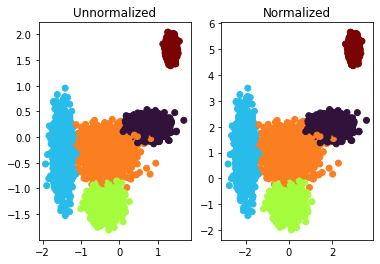

tensor([0.6067, 1.6146]) tensor([3.1633, 4.0514])
tensor([0.0005, 0.0072]) tensor([1.0080, 1.0229])


In [5]:
# INPUT DATA
cmap = "turbo"
mus = torch.Tensor([
    [2, 2],
    [-2,1],
    [0, -1],
    [0, 1],
    [3, 5],
])
stds = torch.Tensor([
    [0.4, 0.2],
    [0.2, 0.7],
    [0.3, 0.3],
    [0.6, 0.4],
    [0.1, 0.2],
])
alphas = torch.Tensor([0.2, 0.2, 0.2, 0.2, 0.2])
dist_in = GMDist(mus, stds, alphas)
#
x,y = dist_in.sample(10000)
normalizer = get_normalizer(x)

x,y = dist_in.sample(10000)
xt = normalizer(x)
#
fig, axes = plt.subplots(1, 2)
axes[0].scatter(xt[:,0], xt[:,1], c=y, cmap=cmap)
axes[0].set_title("Unnormalized")
axes[1].scatter(x[:,0], x[:,1], c=y, cmap=cmap)
axes[1].set_title("Normalized")
plt.show()
#
print(x.mean(axis=0), x.var(axis=0))
print(xt.mean(axis=0), xt.var(axis=0))

LAMBDA: 1.0000


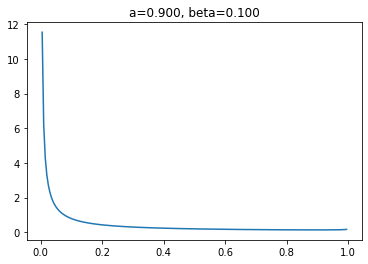

In [6]:
# MODEL
d_in = mus.shape[1]
d_hid = 32
d_out = 5
n_hid = 5
batch_norm = True

# BARLOW LOSS
w_off = 41                  # used with mean
lmbda = calc_lambda(d_out)  # used with sum
lmbda = 1
eps = 1e-8

# BETA LOSS
a_true, b_true = torch.Tensor([0.1, 0.9])
dist_true = Beta(a_true, b_true)

# LOSS
w_beta   = 1
w_barlow = 10

# TRAIN SPEC
batch_size = 1024
num_steps = 500
num_epochs = 10
plot_freq = 5
#
print("LAMBDA: {:.4f}".format(lmbda))
#

plot_beta_pdf(dist_true, "True")

In [7]:
(a_true - 1) / (a_true + b_true - 2)

tensor(0.9000)

### Test Pipleline

LR(X) 0.988
LR(Z) 0.226


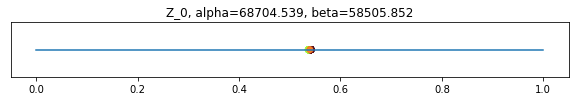

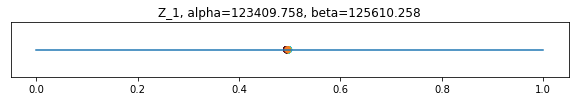

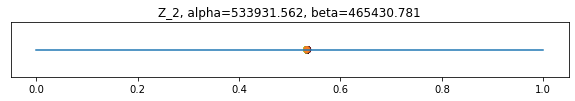

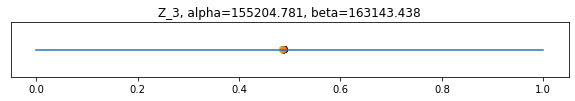

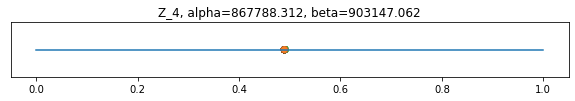

In [8]:
x_train, y_train = dist_in.sample(1000)
x_valid, y_valid = dist_in.sample(1000)
#
x_train = normalizer(x_train)
x_valid = normalizer(x_valid)
#
clf = LogisticRegression(random_state=0).fit(x_train, y_train)
print("LR(X)",clf.score(x_valid, y_valid))
#
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
model.eval()
with torch.no_grad():
    z_train = model(x_train)
    z_valid = model(x_valid)

clf = LogisticRegression(random_state=0).fit(z_train, y_train)
print("LR(Z)",clf.score(z_valid, y_valid))
#
a_z, b_z = beta_params(z_train)
for idx in range(d_out):
    title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
    simplex_plot(z_train[:,idx].detach().numpy(), title=title, c=y_train, cmap=cmap)

### Train

In [9]:
def beta_normalize(x, beta_mean, beta_std):
    return (x - beta_mean) / beta_std

[  1/ 10]██████████500/500, L=12.2, on=0.215, off=0.805, dkl=2.03, a_min=0.199, a_max=0.295, b_min=0.544, b_max=0.
[  2/ 10]██████████500/500, L=10.1, on=0.208, off=0.798, dkl=0.0591, a_min=0.101, a_max=0.114, b_min=0.698, b_max=
[  3/ 10]██████████500/500, L=9.95, on=0.179, off=0.812, dkl=0.0348, a_min=0.0886, a_max=0.118, b_min=0.725, b_max
[  4/ 10]██████████500/500, L=9.9, on=0.173, off=0.817, dkl=0.00884, a_min=0.0974, a_max=0.11, b_min=0.809, b_max=
[  5/ 10]██████████500/500, L=10.1, on=0.213, off=0.791, dkl=0.00822, a_min=0.0951, a_max=0.109, b_min=0.827, b_ma


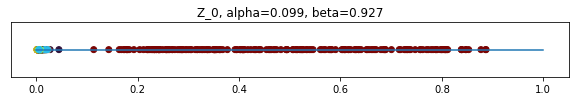

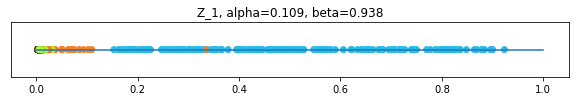

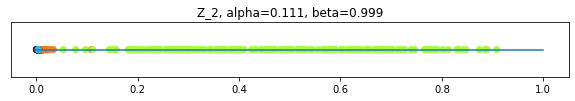

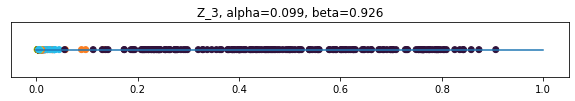

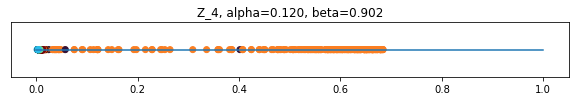

   LINPROB: 0.990


[  6/ 10]██████████500/500, L=10, on=0.206, off=0.792, dkl=0.0282, a_min=0.0837, a_max=0.111, b_min=0.721, b_max=0
[  7/ 10]██████████500/500, L=10.1, on=0.203, off=0.807, dkl=0.0118, a_min=0.0939, a_max=0.111, b_min=0.81, b_max=
[  8/ 10]██████████500/500, L=10.1, on=0.194, off=0.819, dkl=0.0133, a_min=0.0908, a_max=0.112, b_min=0.818, b_max
[  9/ 10]██████████500/500, L=10, on=0.177, off=0.826, dkl=0.00869, a_min=0.0927, a_max=0.111, b_min=0.826, b_max=
[ 10/ 10]██████████500/500, L=10.3, on=0.213, off=0.811, dkl=0.0116, a_min=0.0915, a_max=0.111, b_min=0.8, b_max=0


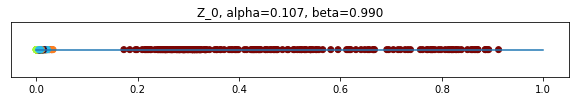

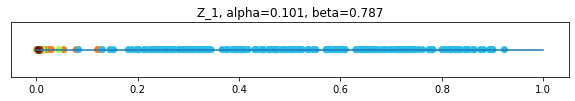

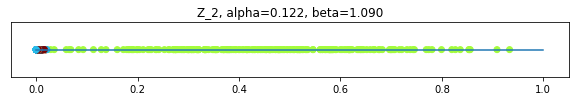

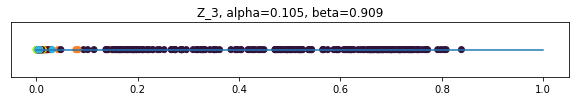

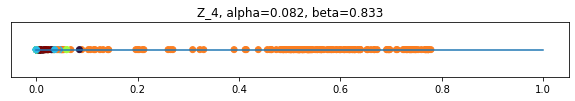

   LINPROB: 0.990


In [12]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    # ##########
    # TRAIN
    # ##########
    model.train()
    desc = "[{:3}/{:3}]".format(epoch_idx, num_epochs)
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{n_fmt}/{total_fmt}{postfix}')
    epoch_loss = 0
    for step in pbar:
        (x1, x2), _ = dist_in.sample_barlow(batch_size)
        x1 = normalizer(x1)
        x2 = normalizer(x2)
        for param in model.parameters():
            param.grad = None
        z1 = model(x1)
        z2 = model(x2)
        
        # BETA LOSS
        a_z, b_z = beta_params(torch.cat([z1, z2], axis=0))
        loss_beta = kl_beta_beta((a_z,b_z),(a_true,b_true),forward=True).sum()
        
        
        ######################
        # BARLOW LOSS
        ######################
        
        # ---------
        # NORMS
        # ---------

        # BATCH NORM
        z1_norm = model.bn(z1)
        z2_norm = model.bn(z2)
        
        # BETA NORM
        #z1_norm = beta_normalize(z1, dist_true.mean, dist_true.stddev)
        #z2_norm = beta_normalize(z2, dist_true.mean, dist_true.stddev)
        
        # CC NORM
        #z1_norm = cc_norm(z1)
        #z2_norm = cc_norm(z1)
        
        c = z1_norm.T @ z2_norm
        c.div_(z1.shape[0])
        
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss_barlow = on_diag + lmbda * off_diag
        
        # LOSS
        loss = w_barlow * loss_barlow + w_beta * loss_beta
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        pbar.set_postfix(
              {'L': loss.item(),
               'on': on_diag.item(),
               'off': off_diag.item(),
               'dkl': loss_beta.item(),
               'a_min': a_z.min().item(),
               'a_max': a_z.max().item(),
               'b_min': b_z.min().item(),
               'b_max': b_z.max().item()
               }
          )

    all_loss.append(epoch_loss / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x, y = dist_in.sample(batch_size)
            x = normalizer(x)
            z = model(x)
            a_z, b_z = beta_params(z)
            #
            for idx in range(d_out):
                title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
                simplex_plot(z[:,idx].detach().numpy(), title=title, c=y, cmap=cmap)
            
            x_train,y_train = dist_in.sample(1000)
            x_valid, y_valid = dist_in.sample(100)
            #
            x_train = normalizer(x_train)
            x_valid = normalizer(x_valid)
            #
            z_train = model(x_train)
            z_valid = model(x_valid)
            #
            clf = LogisticRegression(random_state=0).fit(z_train, y_train)
            print("   LINPROB: {:.3f}".format(clf.score(z_valid, y_valid)))

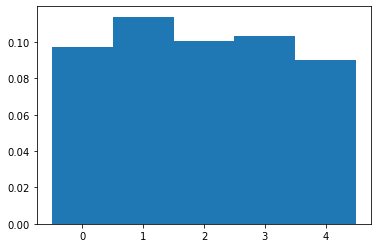

<BarContainer object of 1024 artists>

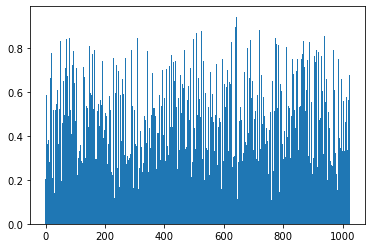

In [13]:
plt.bar(range(d_out), z.mean(axis=0), width=1.0)
plt.show()
plt.bar(range(z.shape[0]), z.sum(axis=1), width=1.0)

In [14]:
with torch.no_grad():
    x, y = dist_in.sample(1000)
    x = normalizer(x)
    z = model(x)
a_z, b_z = beta_params(z)

****************************************************************************************************
CLASS: 0
****************************************************************************************************


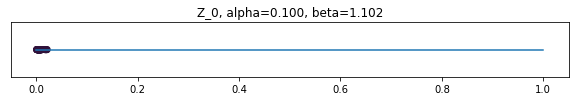

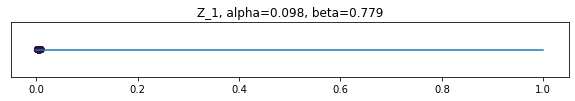

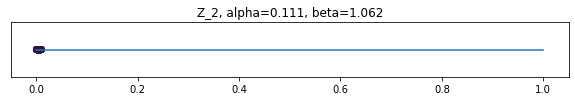

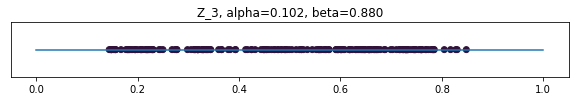

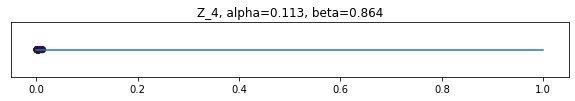

****************************************************************************************************
CLASS: 1
****************************************************************************************************


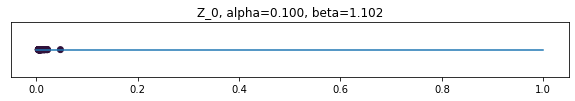

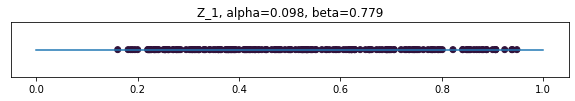

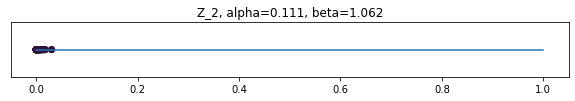

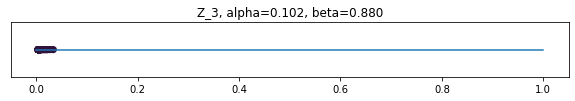

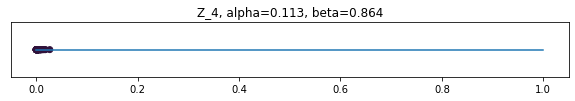

****************************************************************************************************
CLASS: 2
****************************************************************************************************


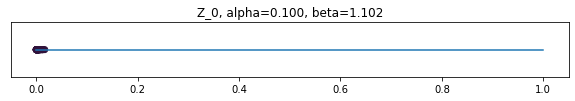

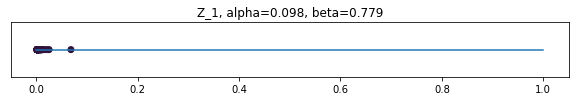

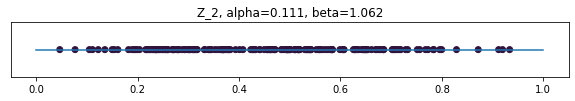

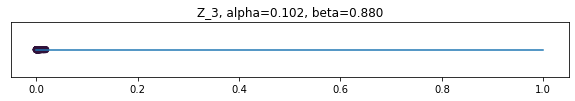

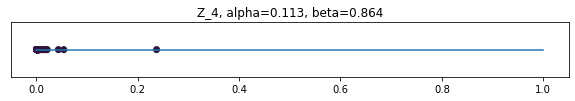

****************************************************************************************************
CLASS: 3
****************************************************************************************************


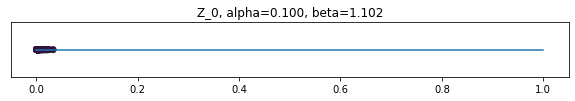

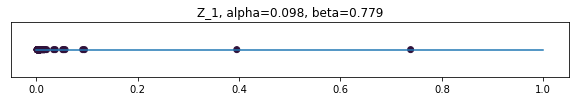

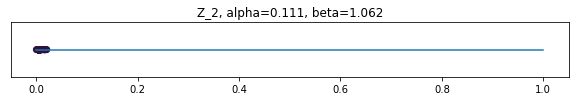

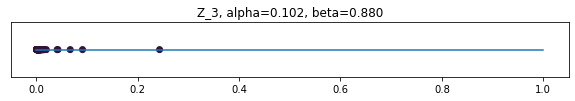

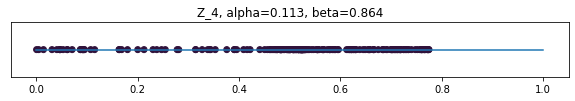

****************************************************************************************************
CLASS: 4
****************************************************************************************************


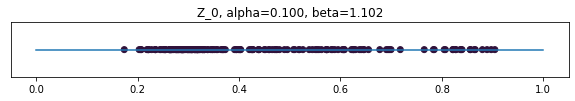

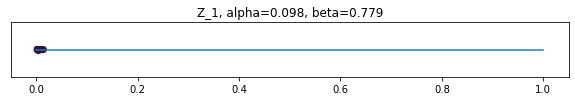

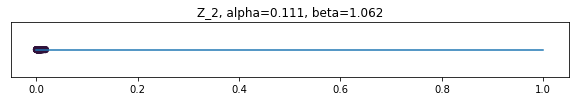

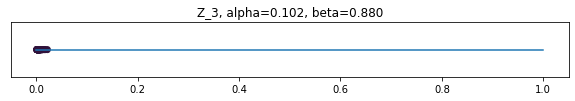

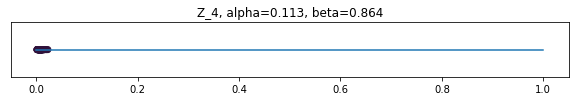

In [15]:
for clz in range(mus.shape[0]):
    print("*"*100)
    print("CLASS: {}".format(clz))
    print("*"*100)
    for idx in range(z.shape[1]):
        show_idcs = (y == clz)
        z_show = z[show_idcs]
        y_show = y[show_idcs]
        title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
        simplex_plot(z_show[:,idx].detach().numpy(), title=title, c=y_show, cmap=cmap)
        

# BETA BARLOWS [SMALLER DIM]

In [18]:
# MODEL
d_out = 2 

# BARLOW LOSS
lmbda = calc_lambda(d_out)  # used with sum
lmbda = 1
print(lmbda)

1


[  1/ 10]██████████500/500, L=0.258, on=0.00106, off=0.000173, dkl=0.246, a_min=0.122, a_max=0.142, b_min=0.513, b
[  2/ 10]██████████500/500, L=0.13, on=0.000708, off=0.0003, dkl=0.119, a_min=0.127, a_max=0.129, b_min=0.644, b_m
[  3/ 10]██████████500/500, L=0.107, on=0.00033, off=0.000439, dkl=0.0995, a_min=0.122, a_max=0.125, b_min=0.648, 
[  4/ 10]██████████500/500, L=0.0795, on=0.000109, off=0.000128, dkl=0.0772, a_min=0.114, a_max=0.121, b_min=0.648
[  5/ 10]██████████500/500, L=0.0782, on=0.000245, off=8.43e-5, dkl=0.0749, a_min=0.116, a_max=0.117, b_min=0.638,


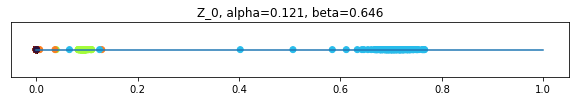

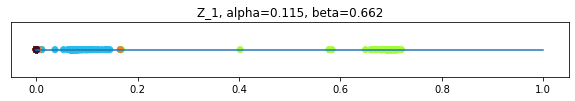

   LINPROB: 0.540


[  6/ 10]██████████500/500, L=0.137, on=0.000816, off=0.000865, dkl=0.12, a_min=0.128, a_max=0.129, b_min=0.651, b
[  7/ 10]██████████500/500, L=0.111, on=0.00038, off=0.000191, dkl=0.106, a_min=0.124, a_max=0.124, b_min=0.646, b
[  8/ 10]██████████500/500, L=0.0671, on=0.000539, off=0.00042, dkl=0.0575, a_min=0.115, a_max=0.115, b_min=0.665,
[  9/ 10]██████████500/500, L=0.147, on=0.00105, off=0.000808, dkl=0.128, a_min=0.134, a_max=0.135, b_min=0.68, b_
[ 10/ 10]██████████500/500, L=0.0546, on=3.51e-5, off=0.00025, dkl=0.0518, a_min=0.113, a_max=0.113, b_min=0.665, 


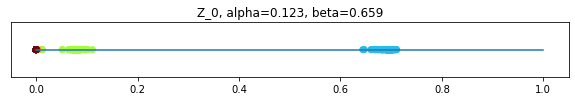

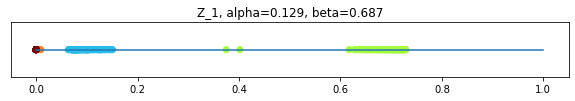

   LINPROB: 0.590


In [19]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    # ##########
    # TRAIN
    # ##########
    model.train()
    desc = "[{:3}/{:3}]".format(epoch_idx, num_epochs)
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{n_fmt}/{total_fmt}{postfix}')
    epoch_loss = 0
    for step in pbar:
        (x1, x2), _ = dist_in.sample_barlow(batch_size)
        x1 = normalizer(x1)
        x2 = normalizer(x2)
        for param in model.parameters():
            param.grad = None
        z1 = model(x1)
        z2 = model(x2)
        
        # BETA LOSS
        a_z, b_z = beta_params(torch.cat([z1, z2], axis=0))
        loss_beta = kl_beta_beta((a_z,b_z),(a_true,b_true),forward=True).sum()
        
        ######################
        # BARLOW LOSS
        ######################
        
        # ---------
        # NORMS
        # ---------

        # BATCH NORM
        z1_norm = model.bn(z1)
        z2_norm = model.bn(z2)
        
        # BETA NORM
        #z1_norm = beta_normalize(z1, dist_true.mean, dist_true.stddev)
        #z2_norm = beta_normalize(z2, dist_true.mean, dist_true.stddev)
        
        # CC NORM
        #z1_norm = cc_norm(z1)
        #z2_norm = cc_norm(z1)
        #
        c = z1_norm.T @ z2_norm
        c.div_(z1.shape[0])
        
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss_barlow = on_diag + lmbda * off_diag
        
        # LOSS
        loss = w_barlow * loss_barlow + w_beta * loss_beta
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        pbar.set_postfix(
              {'L': loss.item(),
               'on': on_diag.item(),
               'off': off_diag.item(),
               'dkl': loss_beta.item(),
               'a_min': a_z.min().item(),
               'a_max': a_z.max().item(),
               'b_min': b_z.min().item(),
               'b_max': b_z.max().item()
               }
          )

    all_loss.append(epoch_loss / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x, y = dist_in.sample(batch_size)
            x = normalizer(x)
            z = model(x)
            a_z, b_z = beta_params(z)
            #
            for idx in range(d_out):
                title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
                simplex_plot(z[:,idx].detach().numpy(), title=title, c=y, cmap=cmap)
            
            x_train,y_train = dist_in.sample(1000)
            x_valid, y_valid = dist_in.sample(100)
            #
            x_train = normalizer(x_train)
            x_valid = normalizer(x_valid)
            #
            z_train = model(x_train)
            z_valid = model(x_valid)
            #
            clf = LogisticRegression(random_state=0).fit(z_train, y_train)
            print("   LINPROB: {:.3f}".format(clf.score(z_valid, y_valid)))

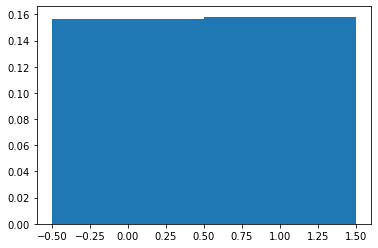

<BarContainer object of 1024 artists>

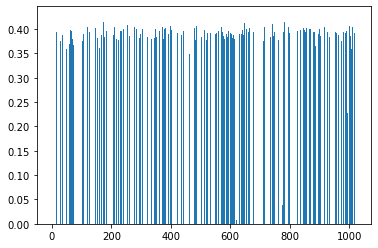

In [20]:
plt.bar(range(d_out), z.mean(axis=0), width=1.0)
plt.show()
plt.bar(range(z.shape[0]), z.mean(axis=1), width=1.0)

In [21]:
with torch.no_grad():
    x, y = dist_in.sample(1000)
    x = normalizer(x)
    z = model(x)
a_z, b_z = beta_params(z)

****************************************************************************************************
CLASS: 0
****************************************************************************************************


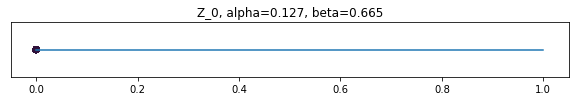

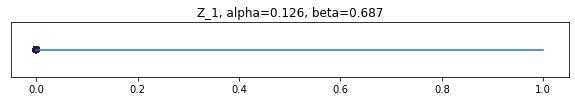

****************************************************************************************************
CLASS: 1
****************************************************************************************************


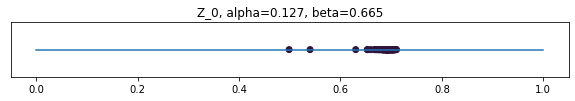

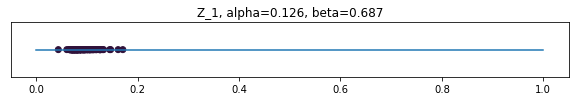

****************************************************************************************************
CLASS: 2
****************************************************************************************************


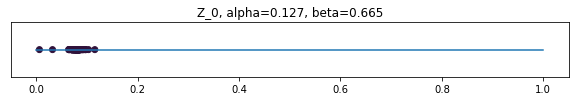

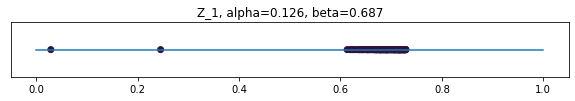

****************************************************************************************************
CLASS: 3
****************************************************************************************************


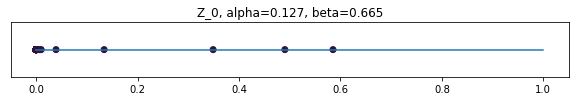

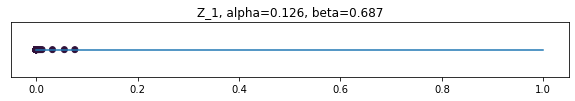

****************************************************************************************************
CLASS: 4
****************************************************************************************************


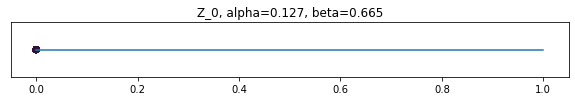

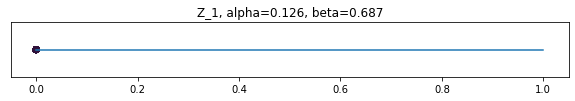

In [22]:
for clz in range(mus.shape[0]):
    print("*"*100)
    print("CLASS: {}".format(clz))
    print("*"*100)
    for idx in range(z.shape[1]):
        show_idcs = (y == clz)
        z_show = z[show_idcs]
        y_show = y[show_idcs]INPROB: 0.970
        title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
        simplex_plot(z_show[:,idx].detach().numpy(), title=title, c=y_show, cmap=cmap)
        

# BETA BARLOWS [TOO MANY DIMS]

In [63]:
# MODEL
d_out = 10 

# BARLOW LOSS
lmbda = calc_lambda(d_out)  # used with sum
lmbda = 0.1
print(lmbda)

0.1


[  1/ 10]██████████500/500, L=14.8, on=0.142, off=11.9, dkl=1.47, a_min=0.122, a_max=0.219, b_min=0.563, b_max=0.8
[  2/ 10]██████████500/500, L=13.1, on=0.199, off=11.1, dkl=0.0636, a_min=0.0984, a_max=0.113, b_min=0.736, b_max=
[  3/ 10]██████████500/500, L=13.2, on=0.164, off=11.5, dkl=0.0412, a_min=0.0972, a_max=0.117, b_min=0.777, b_max=
[  4/ 10]██████████500/500, L=13.2, on=0.19, off=11.2, dkl=0.0429, a_min=0.0903, a_max=0.116, b_min=0.814, b_max=0
[  5/ 10]██████████500/500, L=13, on=0.2, off=11, dkl=0.0345, a_min=0.0894, a_max=0.11, b_min=0.787, b_max=0.888  


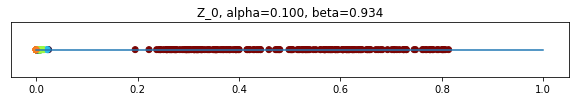

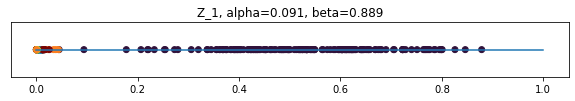

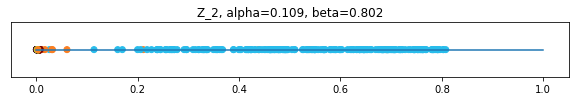

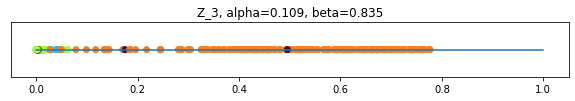

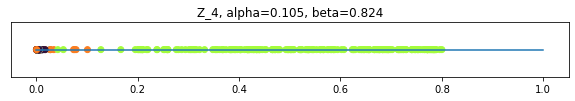

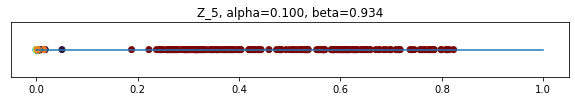

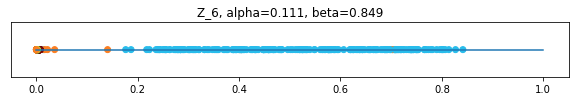

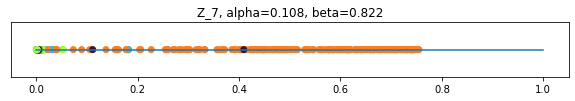

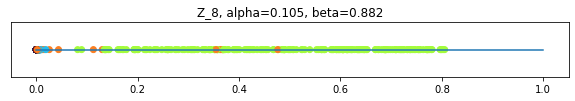

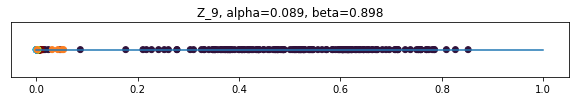

   LINPROB: 0.990


[  6/ 10]██████████500/500, L=13, on=0.142, off=11.6, dkl=0.0306, a_min=0.0915, a_max=0.111, b_min=0.789, b_max=0.
[  7/ 10]██████████500/500, L=13.1, on=0.165, off=11.4, dkl=0.0291, a_min=0.0921, a_max=0.115, b_min=0.823, b_max=
[  8/ 10]██████████500/500, L=13, on=0.15, off=11.4, dkl=0.0302, a_min=0.0937, a_max=0.115, b_min=0.797, b_max=0.9
[  9/ 10]██████████500/500, L=13.1, on=0.178, off=11.3, dkl=0.0171, a_min=0.0924, a_max=0.108, b_min=0.848, b_max=
[ 10/ 10]██████████500/500, L=13.1, on=0.19, off=11.2, dkl=0.0288, a_min=0.0946, a_max=0.117, b_min=0.806, b_max=0


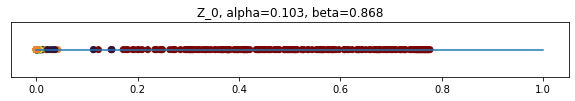

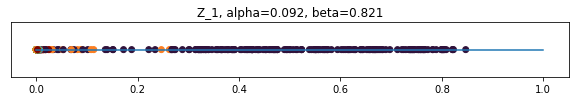

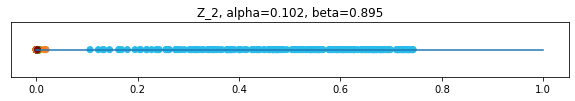

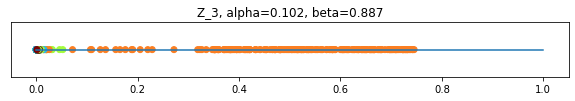

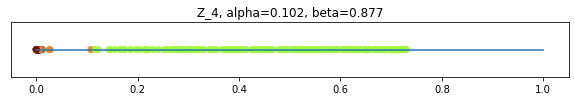

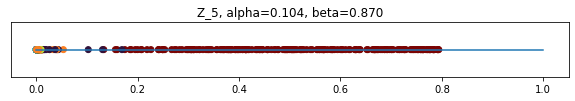

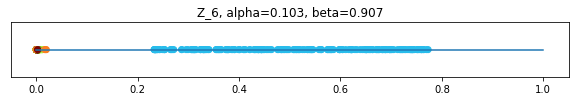

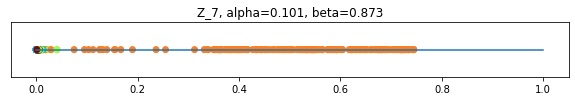

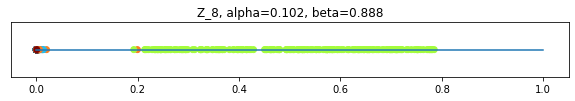

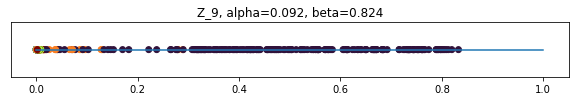

   LINPROB: 0.990


In [64]:
model = Net(d_in=d_in, d_hid=d_hid, n_hid=n_hid, d_out=d_out, batch_norm=batch_norm)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#
all_loss = []
all_a = []
all_b = []
for epoch_idx in range(1, num_epochs + 1, 1):
    # ##########
    # TRAIN
    # ##########
    model.train()
    desc = "[{:3}/{:3}]".format(epoch_idx, num_epochs)
    pbar = tqdm(range(num_steps), bar_format= desc + '{bar:10}{n_fmt}/{total_fmt}{postfix}')
    epoch_loss = 0
    for step in pbar:
        (x1, x2), _ = dist_in.sample_barlow(batch_size)
        x1 = normalizer(x1)
        x2 = normalizer(x2)
        for param in model.parameters():
            param.grad = None
        z1 = model(x1)
        z2 = model(x2)
        
        # BETA LOSS
        a_z, b_z = beta_params(torch.cat([z1, z2], axis=0))
        loss_beta = kl_beta_beta((a_z,b_z),(a_true,b_true),forward=True).sum()
        
        ######################
        # BARLOW LOSS
        ######################
        
        # ---------
        # NORMS
        # ---------

        # BATCH NORM
        z1_norm = model.bn(z1)
        z2_norm = model.bn(z2)
        
        # BETA NORM
        #z1_norm = beta_normalize(z1, dist_true.mean, dist_true.stddev)
        #z2_norm = beta_normalize(z2, dist_true.mean, dist_true.stddev)
        
        # CC NORM
        #z1_norm = cc_norm(z1)
        #z2_norm = cc_norm(z1)
        #
        c = z1_norm.T @ z2_norm
        c.div_(z1.shape[0])
        
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = off_diagonal(c).pow_(2).sum()
        loss_barlow = on_diag + lmbda * off_diag
        
        # LOSS
        loss = w_barlow * loss_barlow + w_beta * loss_beta
        loss.backward()
        optimizer.step()
        #
        epoch_loss += loss.item()
        pbar.set_postfix(
              {'L': loss.item(),
               'on': on_diag.item(),
               'off': off_diag.item(),
               'dkl': loss_beta.item(),
               'a_min': a_z.min().item(),
               'a_max': a_z.max().item(),
               'b_min': b_z.min().item(),
               'b_max': b_z.max().item()
               }
          )

    all_loss.append(epoch_loss / num_steps)
    ############
    # EVAL
    ############
    if epoch_idx % plot_freq == 0:
        model.eval()
        with torch.no_grad():
            x, y = dist_in.sample(batch_size)
            x = normalizer(x)
            z = model(x)
            a_z, b_z = beta_params(z)
            #
            for idx in range(d_out):
                title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
                simplex_plot(z[:,idx].detach().numpy(), title=title, c=y, cmap=cmap)
            
            x_train,y_train = dist_in.sample(1000)
            x_valid, y_valid = dist_in.sample(100)
            #
            x_train = normalizer(x_train)
            x_valid = normalizer(x_valid)
            #
            z_train = model(x_train)
            z_valid = model(x_valid)
            #
            clf = LogisticRegression(random_state=0).fit(z_train, y_train)
            print("   LINPROB: {:.3f}".format(clf.score(z_valid, y_valid)))

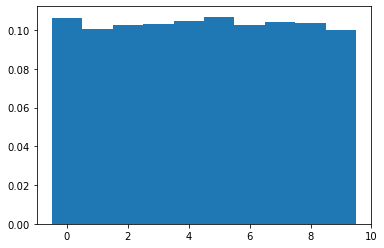

<BarContainer object of 1024 artists>

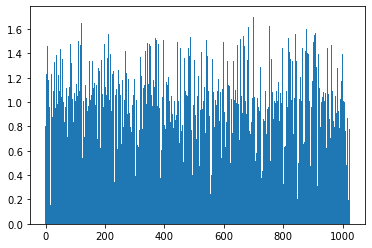

In [65]:
plt.bar(range(d_out), z.mean(axis=0), width=1.0)
plt.show()
plt.bar(range(z.shape[0]), z.sum(axis=1), width=1.0)

In [66]:
with torch.no_grad():
    x, y = dist_in.sample(1000)
    x = normalizer(x)
    z = model(x)
a_z, b_z = beta_params(z)

****************************************************************************************************
CLASS: 0
****************************************************************************************************


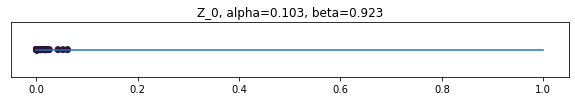

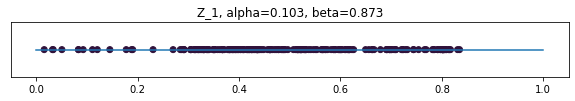

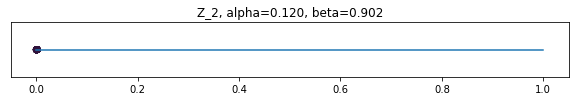

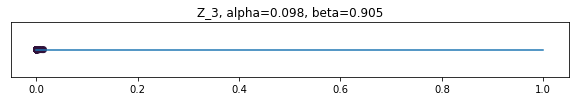

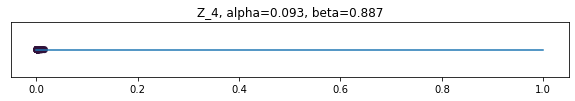

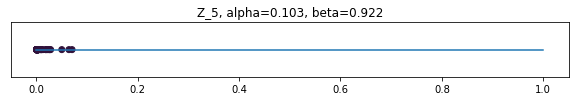

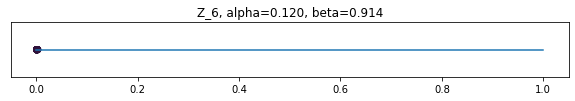

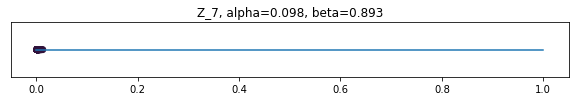

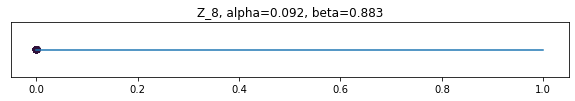

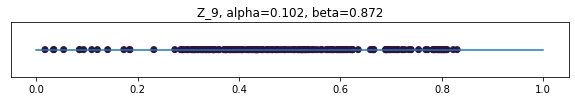

****************************************************************************************************
CLASS: 1
****************************************************************************************************


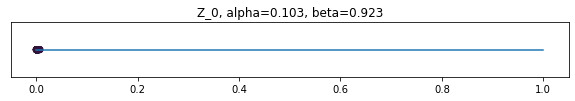

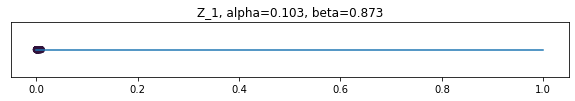

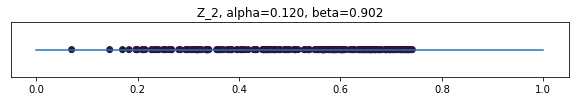

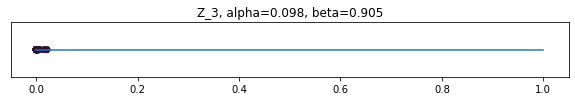

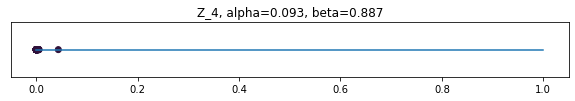

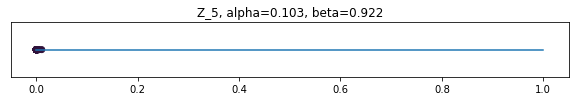

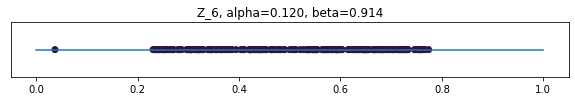

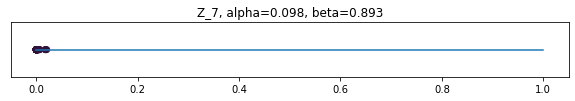

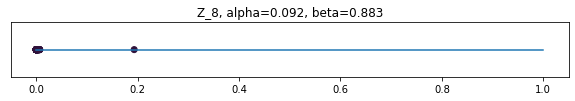

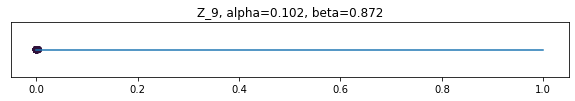

****************************************************************************************************
CLASS: 2
****************************************************************************************************


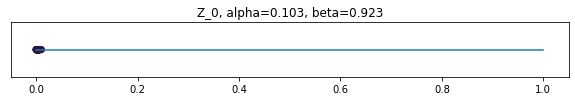

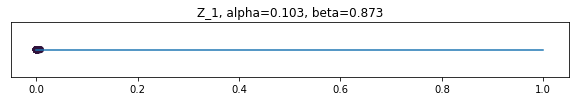

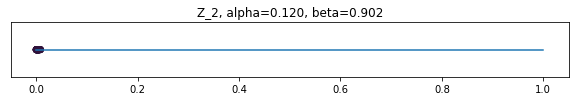

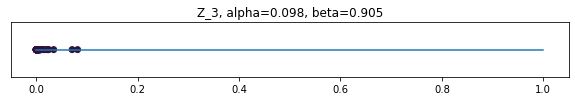

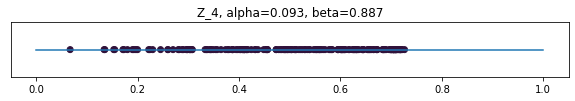

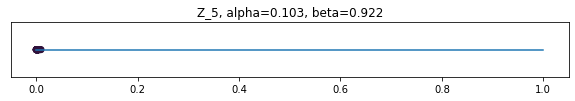

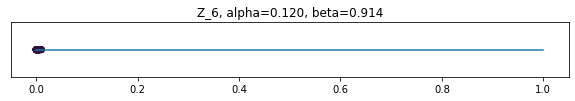

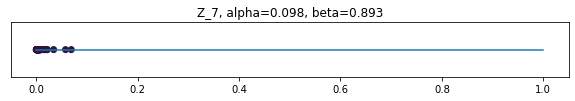

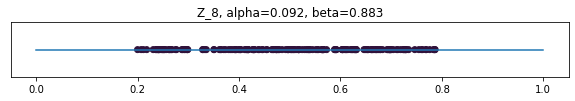

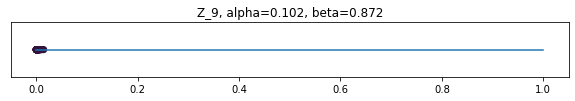

****************************************************************************************************
CLASS: 3
****************************************************************************************************


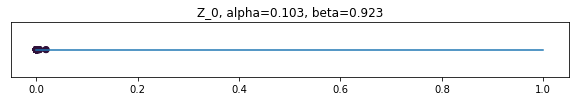

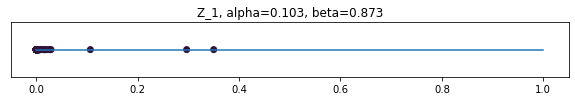

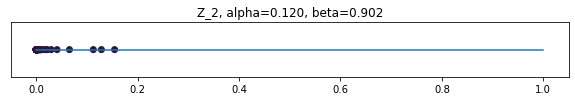

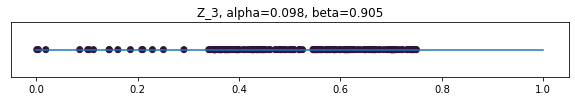

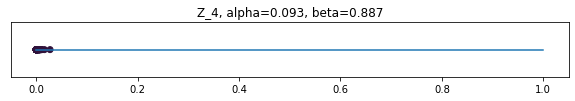

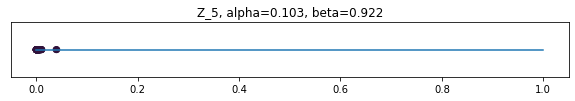

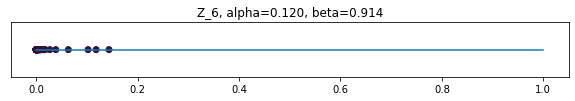

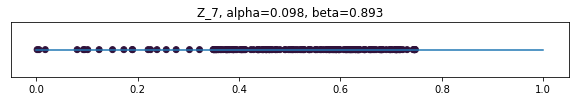

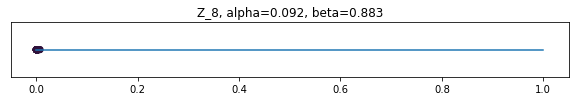

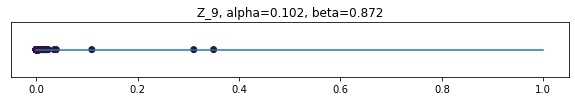

****************************************************************************************************
CLASS: 4
****************************************************************************************************


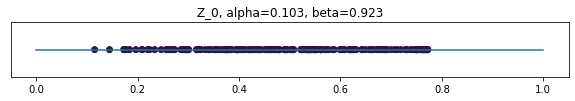

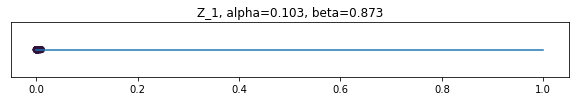

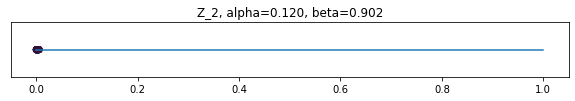

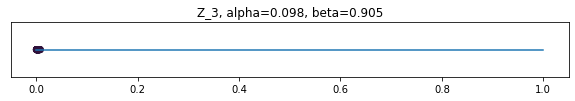

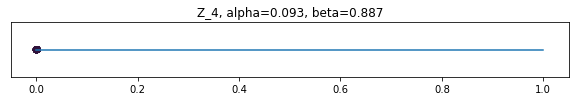

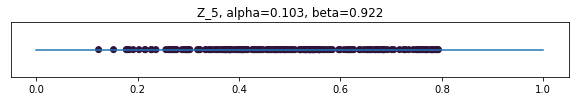

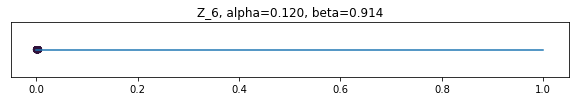

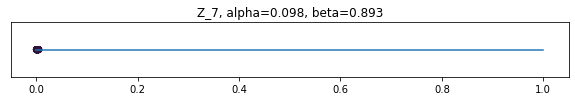

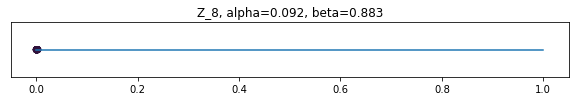

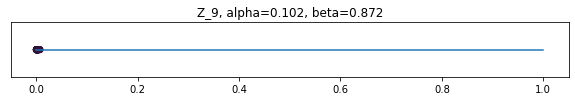

In [67]:
for clz in range(mus.shape[0]):
    print("*"*100)
    print("CLASS: {}".format(clz))
    print("*"*100)
    for idx in range(z.shape[1]):
        show_idcs = (y == clz)
        z_show = z[show_idcs]
        y_show = y[show_idcs]
        title = "Z_{}, alpha={:.3f}, beta={:.3f}".format(idx, a_z[idx].item(), b_z[idx].item())
        simplex_plot(z_show[:,idx].detach().numpy(), title=title, c=y_show, cmap=cmap)
        